# Final Model Testing on Modified Data

In this notebook, I modify my dataset by removing stop words and unique, identifying keywords from each subreddit. I then train and test the optimized models from the previous notebooks on this modified dataset

In [13]:
import pandas as pd
import reddit_functions as rf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

## Find the top twenty words that appear in each subreddit but not the other, and add them to stopwords

In [2]:
# import data
red_df = pd.read_csv('../data/all_posts_cleaned.csv')
red_df.head()

,subreddit,title,selftext,created_utc,num_comments,post_length
0,0,Update from my post about my coworker,Here is the original [post](https://www.reddit...,1648499626,0,189
1,0,You’re forcing me!,"So, for context, I work at a 3-star-ish busine...",1648471124,0,501
2,0,“I actually have to read what I’m signing for?”,So this literally happened as I’m walking in a...,1648445630,0,305
3,0,The Straw(s) That Broke the Camel's Back,"Hey guys, it's been a while since I've posted....",1648441064,0,1185
4,0,DM Report Ideas?,"Hello Front Desk,\n\nApologies if this is agai...",1648435782,0,179


In [3]:
cvec = CountVectorizer(stop_words='english', max_features=100)
vectorized = cvec.fit_transform(red_df['selftext'])
vectorized_df = pd.DataFrame(data=vectorized.todense(), columns=cvec.get_feature_names())
vectorized_df = pd.concat([vectorized_df, red_df[['subreddit']]], axis=1)
vectorized_df.head()

,amp,ask,asked,boss,called,calls,came,card,check,come,...,wasn,way,week,went,work,working,x200b,years,yes,subreddit
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,2,0,...,0,1,0,0,2,0,0,0,0,0
2,0,3,1,0,1,1,1,0,6,0,...,2,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,2,1,2,2,2,...,0,2,0,1,1,1,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [4]:
sub_0 = vectorized_df.groupby('subreddit').get_group(0)
sub_0_most_common = sub_0.drop(columns='subreddit').sum().sort_values(ascending=False).head(50)
sub_0_most_common

room       12513
just       10756
hotel       7473
like        7002
guest       5791
night       5673
don         5649
know        5500
desk        5204
time        5188
check       4799
people      4611
said        4289
going       4067
told        3929
work        3682
didn        3637
ve          3590
day         3588
got         3508
tell        3363
rooms       3345
phone       3235
did         3211
guests      3123
guy         3115
need        3111
come        3104
manager     3005
card        2986
want        2808
make        2758
let         2717
right       2621
ll          2617
shift       2589
really      2484
door        2480
minutes     2368
way         2365
came        2306
ask         2303
sure        2288
asked       2265
left        2239
say         2214
called      2209
later       2173
went        2135
good        2044
dtype: int64

In [5]:
sub_1 = vectorized_df.groupby('subreddit').get_group(1)
sub_1_most_common = sub_1.drop(columns='subreddit').sum().sort_values(ascending=False).head(50)
sub_1_most_common

just        8722
gt          7013
time        5934
work        5805
user        5270
know        4770
like        4732
new         4491
don         4334
computer    4217
company     4076
got         4013
did         3814
phone       3803
need        3754
day         3754
working     3522
support     3512
amp         3313
didn        3230
tech        3154
office      3121
going       3049
customer    3007
help        3001
issue       2937
email       2854
ve          2732
x200b       2706
problem     2660
ll          2632
said        2625
right       2607
people      2562
sure        2428
told        2408
use         2362
manager     2312
make        2270
good        2262
let         2261
guy         2229
look        2226
way         2124
boss        2099
later       2055
years       2053
tell        2053
really      2018
job         2013
dtype: int64

In [6]:
sub_0_unique = set(sub_0_most_common.index).difference(set(sub_1_most_common.index))
sub_0_unique

{'ask',
 'asked',
 'called',
 'came',
 'card',
 'check',
 'come',
 'desk',
 'door',
 'guest',
 'guests',
 'hotel',
 'left',
 'minutes',
 'night',
 'room',
 'rooms',
 'say',
 'shift',
 'want',
 'went'}

In [7]:
sub_1_unique = set(sub_1_most_common.index).difference(set(sub_0_most_common.index))
sub_1_unique


{'amp',
 'boss',
 'company',
 'computer',
 'customer',
 'email',
 'gt',
 'help',
 'issue',
 'job',
 'look',
 'new',
 'office',
 'problem',
 'support',
 'tech',
 'use',
 'user',
 'working',
 'x200b',
 'years'}

In [8]:
sub_1_most_common[sub_1_most_common.index=='use'].values[0]

2362

**add all these words to english stopwords**

In [62]:
from sklearn.feature_extraction import text 

add_words = sub_0_unique.union(sub_1_unique)
stop_words = text.ENGLISH_STOP_WORDS.union(add_words)

In [63]:
print(text.ENGLISH_STOP_WORDS)

frozenset({'wherever', 'hereby', 'another', 'every', 'indeed', 'though', 'you', 'out', 'because', 'is', 'has', 'afterwards', 'nobody', 'me', 'around', 'co', 'fifty', 'whoever', 'get', 'can', 'serious', 'been', 'more', 'here', 'meanwhile', 'they', 'whereupon', 'twelve', 'side', 'few', 'amount', 'seem', 'thru', 'my', 'but', 'whether', 'becoming', 'toward', 'hereupon', 'into', 'either', 'always', 'less', 'find', 'done', 'at', 'go', 'below', 'we', 'well', 'fifteen', 'whence', 'mine', 'since', 'per', 'him', 'a', 'where', 'cry', 'could', 'although', 'anywhere', 'very', 'describe', 'not', 'any', 'who', 'with', 'via', 'thereafter', 'ltd', 'while', 'across', 'rather', 'seems', 'first', 'something', 'himself', 'five', 'us', 'due', 'wherein', 'con', 'from', 'take', 'somehow', 'found', 'sincere', 'some', 'ever', 'eg', 'between', 'still', 'only', 'her', 'together', 'hundred', 'whereas', 'those', 'much', 'whenever', 'about', 'former', 'also', 'beyond', 'whole', 'ourselves', 'may', 're', 'now', 'besi

In [64]:
print(stop_words)

frozenset({'wherever', 'thin', 'hereby', 'another', 'every', 'indeed', 'though', 'formerly', 'you', 'out', 'guests', 'shift', 'because', 'is', 'has', 'nine', 'tech', 'afterwards', 'through', 'nobody', 'each', 'email', 'me', 'around', 'co', 'else', 'fifty', 'so', 'ask', 'whoever', 'get', 'in', 'gt', 'again', 'was', 'can', 'such', 'than', 'serious', 'myself', 'onto', 'been', 'more', 'already', 'give', 'working', 'here', 'an', 'meanwhile', 'ie', 'whereafter', 'card', 'they', 'un', 'whereupon', 'see', 'became', 'twelve', 'x200b', 'side', 'almost', 'few', 'eleven', 'amount', 'empty', 'seem', 'thru', 'my', 'forty', 'but', 'whether', 'years', 'becoming', 'toward', 'twenty', 'office', 'often', 'hereupon', 'into', 'either', 'always', 'might', 'new', 'less', 'boss', 'find', 'what', 'never', 'use', 'done', 'seemed', 'at', 'go', 'sometime', 'therefore', 'hotel', 'made', 'below', 'we', 'de', 'perhaps', 'well', 'it', 'fifteen', 'whence', 'am', 'whatever', 'too', 'will', 'least', 'mine', 'since', 'am

**Visualizations of unique top words for each subreddit**

In [10]:
sub_1_unique_pd = pd.Series(index=list(sub_1_unique), 
                            data=[sub_1_most_common[sub_1_most_common.index==word].values[0] for word in sub_1_unique]).sort_values(ascending=False)
sub_0_unique_pd = pd.Series(index=list(sub_0_unique),
                            data=[sub_0_most_common[sub_0_most_common.index==word].values[0] for word in sub_0_unique]).sort_values(ascending=False)

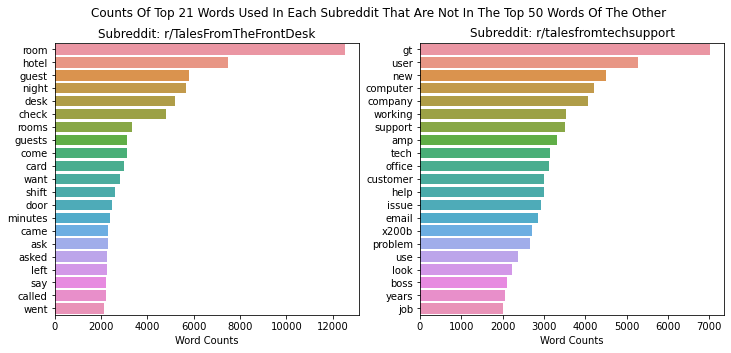

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('Counts of top 21 words used in each subreddit that are not in the top 50 words of the other'.title())

sns.barplot(x=sub_0_unique_pd.values, y=sub_0_unique_pd.index, ax=ax[0])
ax[0].set_xlabel('Word Counts')
ax[0].set_title('Subreddit: r/TalesFromTheFrontDesk')

sns.barplot(x=sub_1_unique_pd.values, y=sub_1_unique_pd.index, ax=ax[1])
ax[1].set_xlabel('Word Counts')
ax[1].set_title('Subreddit: r/talesfromtechsupport');

plt.savefig('../figures/top_words.png', dpi=300, bbox_inches = "tight")

## Now, rerun all the models on text with these words removed

### Import train and test sets

In [15]:
# import data
X_train = pd.read_csv('../data/train_test_sets/X_train.csv')
X_train = X_train['selftext'] # convert from dataframe to series

X_test = pd.read_csv('../data/train_test_sets/X_test.csv')
X_test = X_test['selftext'] # convert from dataframe to series

y_train = pd.read_csv('../data/train_test_sets/y_train.csv')
y_train = y_train['subreddit'] # convert from dataframe to series

y_test = pd.read_csv('../data/train_test_sets/y_test.csv')
y_test = y_test['subreddit'] # convert from dataframe to series 

### Logistic Regression

In [16]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words)),
    ('model', LogisticRegression())
])

params = {
     'model__C': [1],
     'model__penalty': ['l2'],
     'model__solver': ['liblinear'],
     'tvec__max_df': [0.8],
     'tvec__max_features': [None]
}

gs = GridSearchCV(pipe, params, cv=3, scoring='recall')
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters:')
gs.best_params_

Best Score: 0.9754385964912281
Best Parameters:


{'model__C': 1,
 'model__penalty': 'l2',
 'model__solver': 'liblinear',
 'tvec__max_df': 0.8,
 'tvec__max_features': None}

In [17]:
gs.score(X_test, y_test)

0.9829467939972715

In [18]:
preds_logreg = gs.predict(X_test)

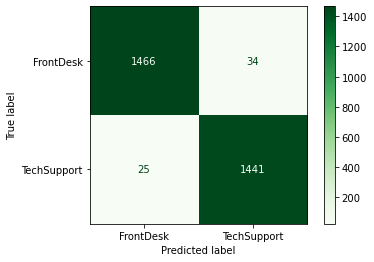

In [19]:
plot_confusion_matrix(gs, X_test, y_test, display_labels=['FrontDesk', 'TechSupport'], cmap='Greens');

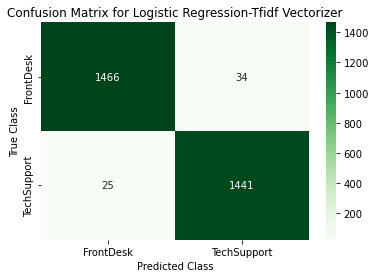

In [49]:
conf_matrix = confusion_matrix(y_test, preds_logreg)
conf_matrix


sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d',
            cmap='Greens',
            yticklabels=['FrontDesk', 'TechSupport'],
            xticklabels=['FrontDesk', 'TechSupport'])
plt.title('Confusion Matrix for Logistic Regression-Tfidf Vectorizer');
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.savefig('../figures/logreg.png', dpi=300, bbox_inches = "tight")

### Multinomial Naive Bayes

0.9864146176319386


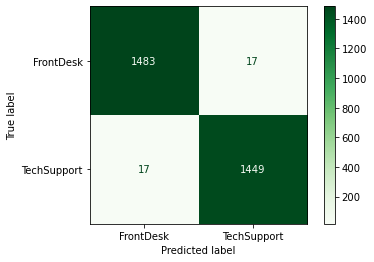

In [37]:
pipe_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

params_mnb = {'cvec__max_df': [0.8],
     'cvec__max_features': [3500],
     'mnb__alpha': [0.001]}

gs_mnb = GridSearchCV(pipe_mnb, params_mnb)
gs_mnb.fit(X_train, y_train)
print(gs_mnb.best_score_)


plot_confusion_matrix(gs_mnb, X_test, y_test, display_labels=['FrontDesk', 'TechSupport'], cmap='Greens');

In [38]:
gs_mnb.best_params_

{'cvec__max_df': 0.8, 'cvec__max_features': 3500, 'mnb__alpha': 0.001}

In [39]:
gs_mnb.score(X_test, y_test)

0.9885367498314228

In [40]:
preds_mnb = gs_mnb.predict(X_test)

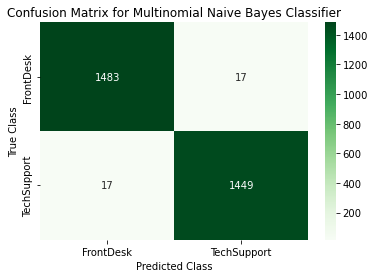

In [48]:
conf_matrix = confusion_matrix(y_test, preds_mnb)
conf_matrix

sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d',
            cmap='Greens',
            yticklabels=['FrontDesk', 'TechSupport'],
            xticklabels=['FrontDesk', 'TechSupport'])
plt.title('Confusion Matrix for Multinomial Naive Bayes Classifier');
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.savefig('../figures/mnb.png', dpi=300, bbox_inches = "tight")

## Support Vector Machine with Count Vectorizer

In [26]:
pipe_svm = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('svm', SVC())
])

params_svm = {'cvec__max_df': [0.8],
     'cvec__max_features': [2500],
     'svm__kernel': ['rbf']}

gs_svm = GridSearchCV(pipe_svm, params_svm)
gs_svm.fit(X_train, y_train)
print(gs_svm.best_score_)

0.961120793784142


In [27]:
gs_svm.best_params_

{'cvec__max_df': 0.8, 'cvec__max_features': 2500, 'svm__kernel': 'rbf'}

In [28]:
gs_svm.score(X_test, y_test)

0.9720161834120027

In [29]:
preds_svm = gs_svm.predict(X_test)

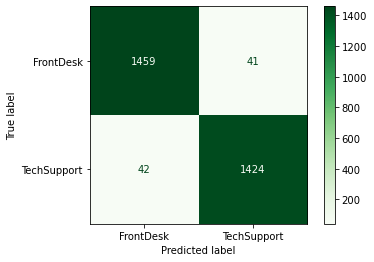

In [30]:
plot_confusion_matrix(gs_svm, X_test, y_test, display_labels=['FrontDesk', 'TechSupport'], cmap='Greens');

## Support Vector Machine with TF-IDF Vectorizer

0.9872812516979508


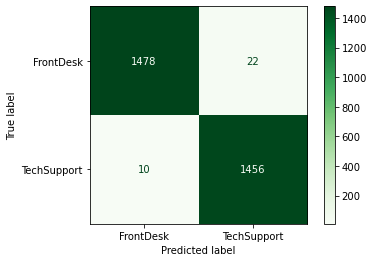

In [42]:
pipe_svm = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())
])

params_svm = {
    'svm__kernel': ['sigmoid'],
    'tvec__max_df':[ 0.7],
    'tvec__max_features': [None]
}

gs_svm = GridSearchCV(pipe_svm, params_svm)
gs_svm.fit(X_train, y_train)
print(gs_svm.best_score_)


plot_confusion_matrix(gs_svm, X_test, y_test, display_labels=['FrontDesk', 'TechSupport'], cmap='Greens');

In [43]:
gs_svm.best_params_

{'svm__kernel': 'sigmoid', 'tvec__max_df': 0.7, 'tvec__max_features': None}

In [44]:
gs_svm.score(X_test, y_test)

0.9892110586648685

In [45]:
preds_svm_tvec = gs_svm.predict(X_test)

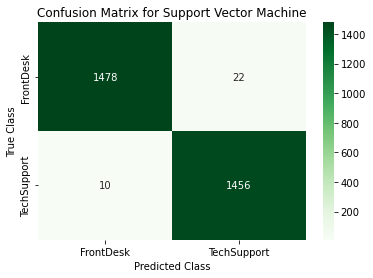

In [47]:
conf_matrix = confusion_matrix(y_test, preds_svm_tvec)
conf_matrix

sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d',
            cmap='Greens',
            yticklabels=['FrontDesk', 'TechSupport'],
            xticklabels=['FrontDesk', 'TechSupport'])
plt.title('Confusion Matrix for Support Vector Machine');
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.savefig('../figures/svm.png', dpi=300, bbox_inches = "tight")

### voting classifier

In [53]:
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier)
from sklearn.tree import DecisionTreeClassifier

In [54]:
vote = VotingClassifier([
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier())), #specify base estimator 
                                                    # if you want to tune over those parameters
    ('gbc', GradientBoostingClassifier()),
    ('logreg', LogisticRegression(solver='saga', max_iter=2000))
])

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('model', vote)
])



In [55]:
params = {
     'cvec__max_df': [1.0],
     'cvec__max_features': [None],
     'model__ada__base_estimator__max_depth': [3],
     'model__ada__base_estimator__min_samples_split': [5],
     'model__gbc__n_estimators': [100]
}

gs_vc = GridSearchCV(pipe, params, cv=5)

gs_vc.fit(X_train, y_train)
print(gs_vc.best_score_)
gs_vc.best_params_

0.9755750044930389


{'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'model__ada__base_estimator__max_depth': 3,
 'model__ada__base_estimator__min_samples_split': 5,
 'model__gbc__n_estimators': 100}

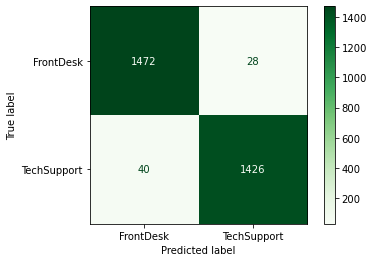

In [56]:
plot_confusion_matrix(gs_vc, X_test, y_test, display_labels=['FrontDesk', 'TechSupport'], cmap='Greens');

In [57]:
preds_vc = gs_vc.predict(X_test)

Save all predictions

In [60]:
predictions = pd.DataFrame({
    'X_test': X_test,
    'y_true': y_test,
    'y_logreg': preds_logreg,
    'y_mnb' : preds_mnb,
    'y_svm': preds_svm_tvec,
    'y_vc' : preds_vc
})

predictions.head()

,X_test,y_true,y_logreg,y_mnb,y_svm,y_vc
0,Once upon a time it was a normal day at the ai...,0,0,0,0,0
1,I once worked as a programmer for a company th...,1,1,1,1,1
2,To set the scene: I'm genderqueer. Born with b...,0,0,0,0,0
3,"So, it won't let me edit the previous post, so...",0,0,0,0,0
4,"At $Hospital, we used $WellKnownBrand printers...",1,1,1,1,1


In [61]:
predictions.to_csv('../data/predictions/predictions_unique_removed.csv', index=False)